##### Time Series

###### Objective
Based on the data from 

spurious correlation  - 2 series of values which are completely unrelated, however shows a higher correlation between one other. 

When looking at correlation always look at the percentage change and not the actual value aganist one another. 

Why we add 1 to the intercept before applying the linear model ? 
reason - the model will assume there is no intercept hence we would need to provide a value in this case 1 as the intercept. 

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np

In [2]:
import os
os.chdir('C:\\Users\\bhara\\PycharmProjects\\TimeSeries')

In [3]:
weather_file = 'Fort_Lauderdale.csv'
path=os.path.join(os.getcwd(),weather_file)
weather_file = open(path)
weather_data = weather_file.read()
weather_file.close()
print(len(weather_data))

1289770


In [4]:
lines = weather_data.split('\n')

In [5]:
print(len(lines))

23789


In [6]:
labels = lines[0]
values = lines[1:]
n_values = len(values)

In [7]:
# split the list of comma separated strings
year = []
month = []
day = []
max_temp = []

In [8]:
# take out the column values and put them into the list
c_year = 1
c_month = 2
c_day = 3
c_max_temp = 5

In [9]:
for irow in range(n_values):
    split_values = values[irow].split(',')
    year.append(int(split_values[c_year]))
    month.append(int(split_values[c_month]))
    day.append(int(split_values[c_day]))
    max_temp.append(float(split_values[c_max_temp]))
    
# plt.plot(max_temp)
# plt.show()

In [10]:
i_mid = len(max_temp) // 2
temps = np.array(max_temp[i_mid:])
year = year[i_mid:]
month = month[i_mid:]
day = day[i_mid:]
temps[np.where(temps == -99.9)] = np.nan

<IPython.core.display.Javascript object>


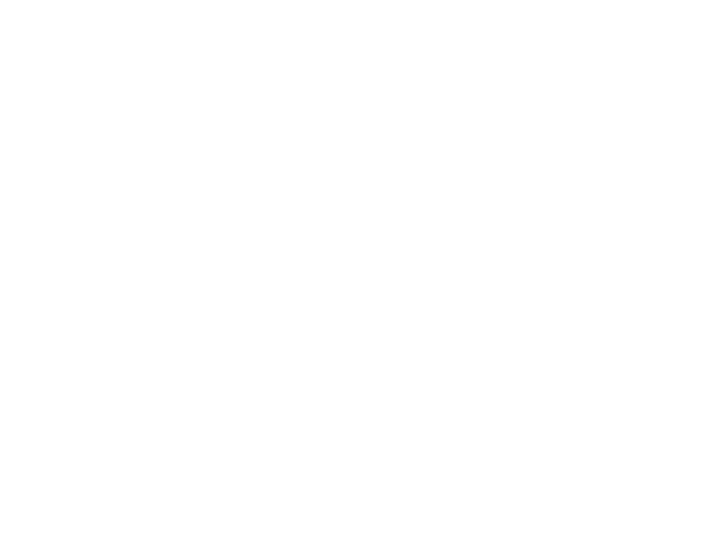

In [11]:
plt.close()
plt.plot(temps,color='white',marker='.',linestyle=None)
plt.show()

In [12]:
print(np.where(np.isnan(temps))[0])

[    0     1     2 ... 11785 11786 11807]


In [13]:
print(np.where(np.logical_not(np.isnan(temps)))[0])

[ 5155  5156  5157 ... 11891 11892 11893]


In [14]:
start = np.where(np.logical_not(np.isnan(temps)))[0][0]

In [15]:
print(start)

5155


In [16]:
temps = temps[start:]
year = year[start:]
month = month[start:]
day = day[start:]

In [17]:
temps[0]

91.0

In [18]:
difference = np.where(np.isnan(temps))[0]

In [19]:
print(np.diff(difference)[:20])

[  7   4  10   8  66  55 229   1   1  13   1 448  39 366  73   4 289 553
   1   1]


Taking care of the missing value 

In [20]:
for i in range(temps.size):
    if np.isnan(temps[i]):
        temps[i] = temps[i -1]

<IPython.core.display.Javascript object>


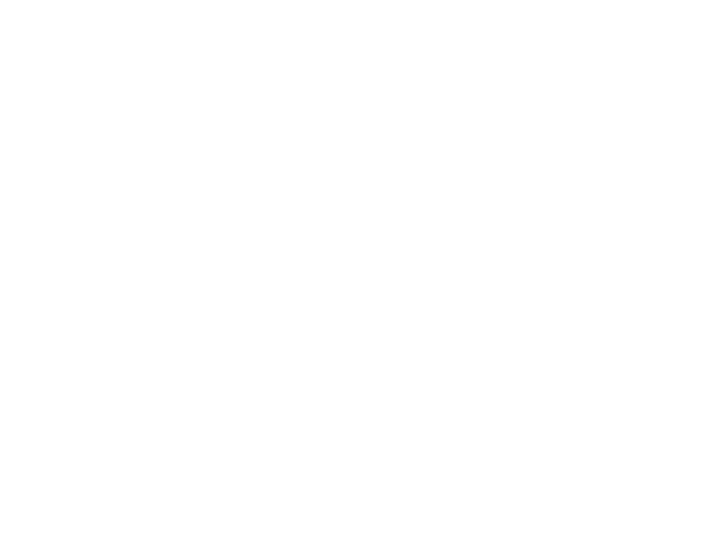

In [21]:
plt.close()
plt.plot(temps)
plt.show()

<IPython.core.display.Javascript object>


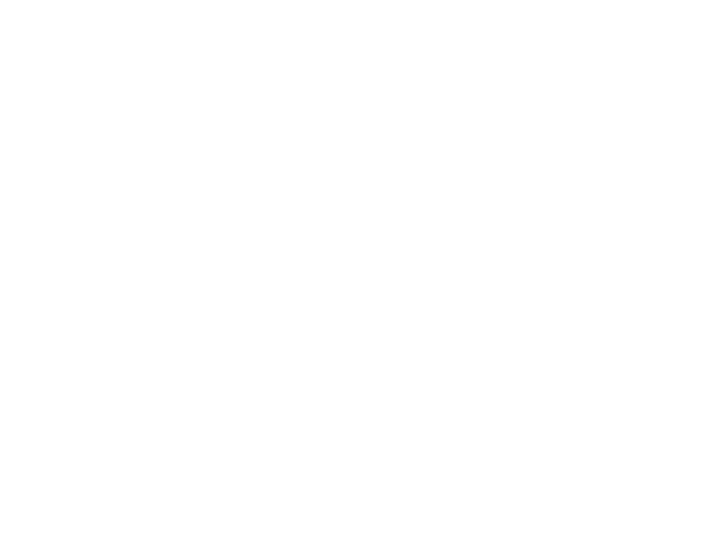

In [22]:
# Find the Autocorelation 
plt.close()
plt.plot(temps[:-1],temps[1:],color='white',linestyle='',marker='.')
plt.show()

In [23]:
# adding jitter 
def scatter_jitter(x,y):
    x_jitter = x + np.random.normal(size=x.size, scale=0.5)
    y_jitter = y + np.random.normal(size=y.size, scale=0.5)
    plt.close()
    plt.plot(x_jitter,y_jitter,color='white',alpha=0.1,marker='.',linestyle='')
    plt.show()

<IPython.core.display.Javascript object>


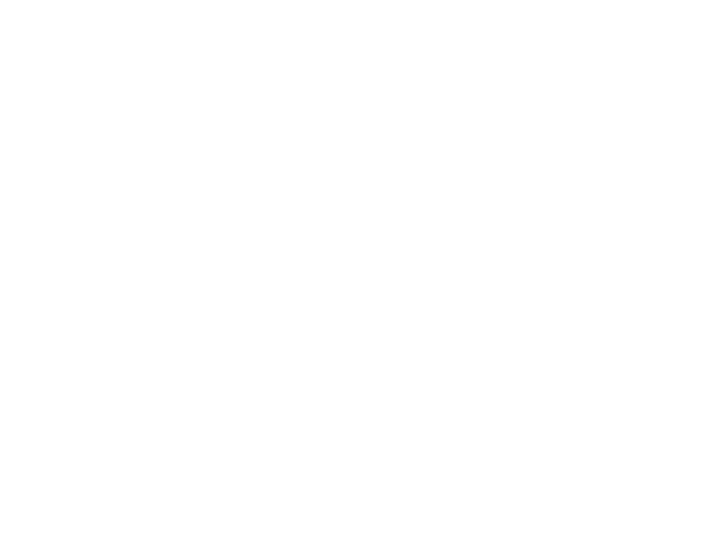

In [24]:
shift = 1
scatter_jitter(temps[:-shift],temps[shift:])

In [25]:
print(np.corrcoef(temps[:-shift],temps[shift:]))

[[1.         0.85079698]
 [0.85079698 1.        ]]


In [26]:
autocorr = []
for shift in range(1,1000):
    correlation = np.corrcoef(temps[:-shift],temps[shift:])[0][1]
    autocorr.append(correlation)

<IPython.core.display.Javascript object>


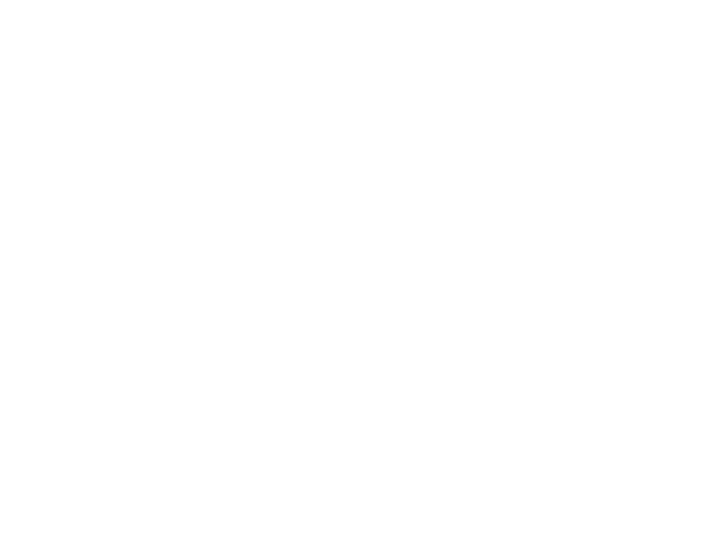

In [27]:
plt.close()
plt.plot(autocorr)
plt.show()

Adding the sign wave to the above plot

In [28]:
d = np.arange(1,1000)
fit = 0.6 * np.cos(2 * np.pi* d / 365)
plt.plot(d,fit,color='red')
plt.show()

annual trend shows clear domination over the weather data. 
we take annual trend as the feature. 

We calculate the median for a 10 day range for each day for the entire year. 


In [29]:
def find_day_of_year(year,month,day):
    days_per_month = np.array([
        31, # January
        28, # February
        31, # March
        30, # April
        31, # May
        30, # June
        31, # July
        31, # August
        30, # September
        31, # October
        30, # November
        31  # December
    ])
    # Leap year 
    if year % 4 == 0:
        days_per_month[1] += 1
        
    day_of_year = np.sum(np.array(days_per_month[:month] - 1)) + day - 1
    return day_of_year

<IPython.core.display.Javascript object>


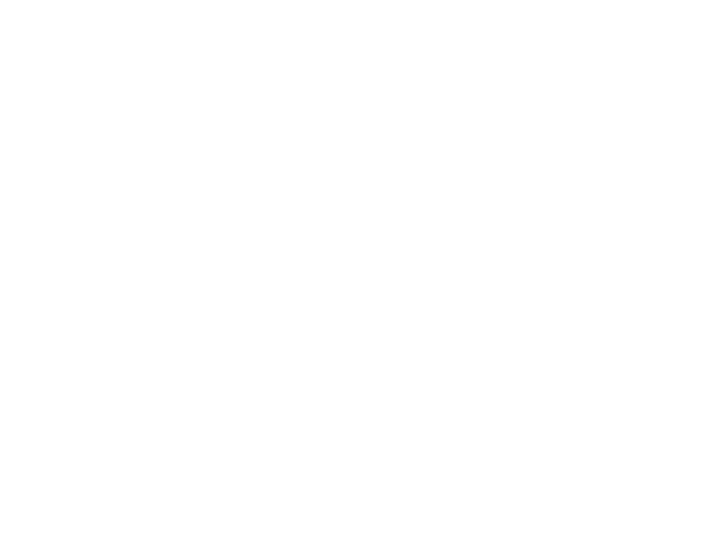

In [30]:
day_of_year = np.zeros(temps.size)
for i_row in range(temps.size):
    day_of_year[i_row] = find_day_of_year(year[i_row],month[i_row],day[i_row])
    
scatter_jitter(day_of_year,temps)


In [37]:
median_temp_calendar = np.zeros(366)
ten_day_medians = np.zeros(temps.size)
for i_day in range(0,365):
    low_day = i_day - 5
    high_day = i_day + 4
    if low_day < 0:
        low_day += 365
    if high_day > 365:
        high_day += -365 
    if low_day < high_day:
        i_window_day = np.where(
            np.logical_and(day_of_year >= low_day,
                          day_of_year <= high_day))
    else:
        i_window_day = np.where(
                np.logical_or(day_of_year >= low_day,
                              day_of_year >= high_day))
    ten_day_median = np.median(temps[i_window_day])
    median_temp_calendar[i_day] = ten_day_median
    ten_day_medians[np.where(day_of_year == i_day)] = ten_day_median
    
    if i_day == 364:
        ten_day_medians[np.where(day_of_year == 365)] = ten_day_median
        median_temp_calendar[365] = ten_day_median
print(ten_day_medians.size,np.unique(ten_day_medians),ten_day_medians)

6739 [ 0.  76.  76.5 77.  77.5 78.  79.  79.5 80.  81.  82.  83.  83.5 84.
 84.5 85.  85.5 86.  87.  88.  89.  90.  91. ] [90. 90. 90. ...  0.  0.  0.]


<IPython.core.display.Javascript object>


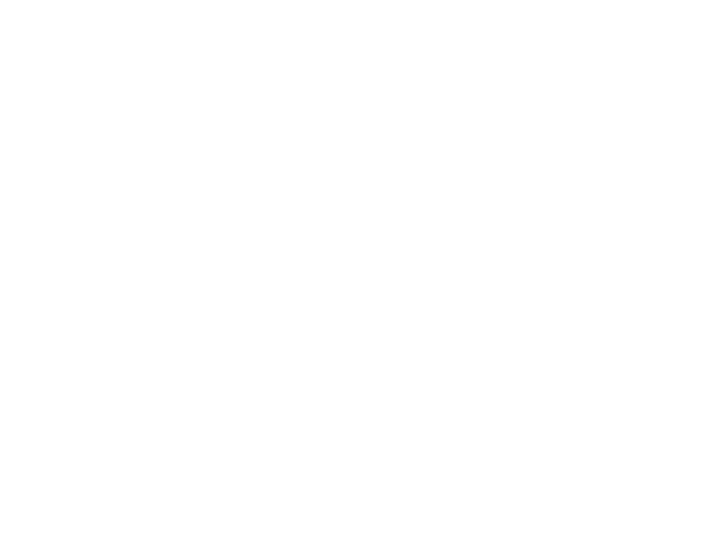

In [32]:
scatter_jitter(ten_day_medians,temps)

<IPython.core.display.Javascript object>


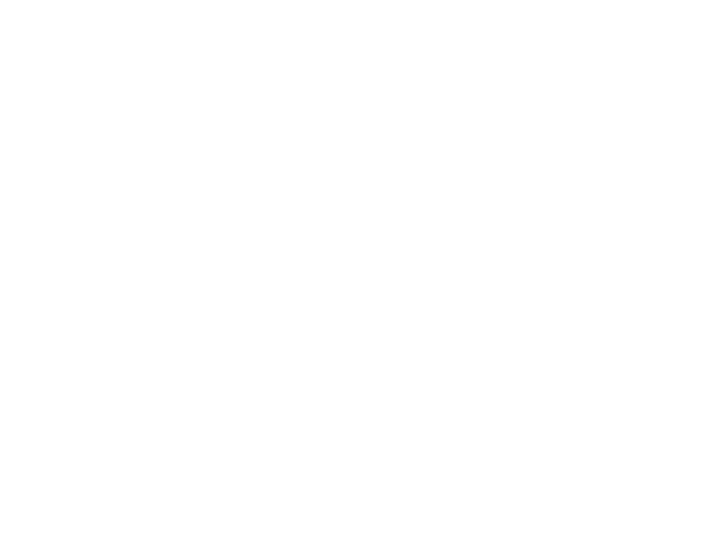

In [33]:
scatter_jitter(ten_day_medians,temps - ten_day_medians)

<IPython.core.display.Javascript object>


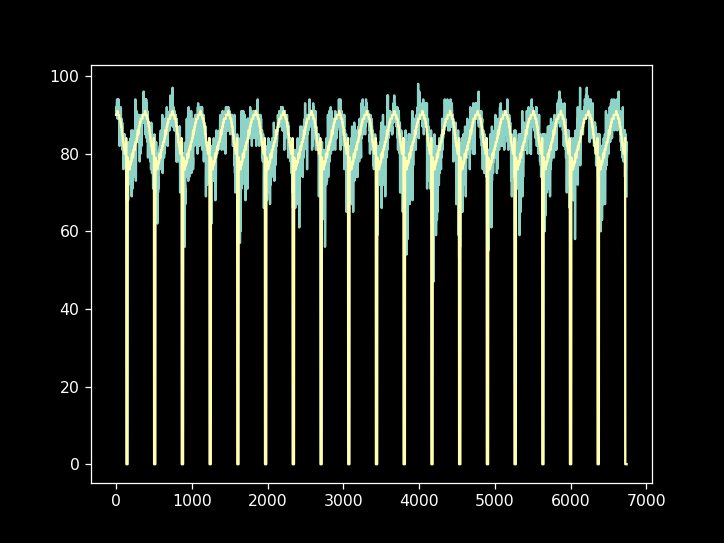

In [34]:
plt.close()
plt.plot(temps)
plt.plot(ten_day_medians)
plt.show()

In [35]:
temps[np.where(temps == 40.0)]

array([], dtype=float64)